# Big Data in Finance: In-Class Presentation

In [129]:
import time
import pandas as pd
import datetime as dt
import helper_functs as hf
import warnings
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

# Loading Dataset
There are three datasets:
- **Returns Clean**: Daily stock returns for 100 (randomly sampled) New York Stock Exchange (NYSE) listed stocks 
- **Flows Clean**: Matched institutional net trading flows, from 1993-04-01to 2000-12-29. 
- **PERMNO Tickers**: Link between the PERMNOs contained in the two previous files to stock ticker symbols

In [130]:
returns = pd.read_excel("data_sources/Returns_Clean.xlsx", index_col="Dates")
returns.index = pd.to_datetime(returns.index,format='%Y%m%d').date
returns.name = "RETURNS"

flows = pd.read_excel("data_sources/Flows_Clean.xlsx", index_col="Dates")
flows.index = pd.to_datetime(flows.index, format='%Y%m%d').date
flows.name = "FLOWS"

tickers = pd.read_excel("data_sources/PERMNO_Tickers.xlsx", index_col="Dates")
tickers.index = pd.to_datetime(tickers.index,  format='%Y%m%d').date
tickers.name = "TICKERS"

# Warm-Up

In [3]:
all_stocks =pd.DataFrame(index=returns.index) # empty df, where we append all our results
PERMNO = list(returns.columns) #PERMNO is the same everywhere, i.e. tickers, flows, returns
WINDOW_SIZES = [5,25,250]

### Rolling MA Benchmark

In [4]:
for WINDOW_SIZE in WINDOW_SIZES:
    all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] = 0
    for number in PERMNO:
        stock = hf.create_stock_df(number,[flows, returns,tickers])
        stock_lagged = hf.get_lags(stock, 3).dropna()
        stock_X, stock_Y = hf.x_y_split(stock_lagged)
        stock_SMA = copy.deepcopy(stock_Y)
        stock_SMA.columns = [f'{number}_RETURNS' if x=='RETURNS' else x for x in stock_SMA.columns]
        
        stock_SMA[
            f"{number}_SMA_{WINDOW_SIZE}_PRED"]=stock_SMA[
            f'{number}_RETURNS'].rolling(WINDOW_SIZE).mean().shift(1)
        stock_SMA = stock_SMA.dropna()
        
        stock_SMA[
            f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"]=(stock_SMA[
            f"{number}_SMA_{WINDOW_SIZE}_PRED"]-stock_SMA[f'{number}_RETURNS'])**2
        
        stock_SMA[
            f"{number}_SMA_{WINDOW_SIZE}_RMSE"] = stock_SMA[
            f"{number}_SMA_{WINDOW_SIZE}_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
        
        all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"] += stock_SMA[f"{number}_SMA_{WINDOW_SIZE}_RMSE"]
        all_stocks[stock_SMA.columns]= stock_SMA

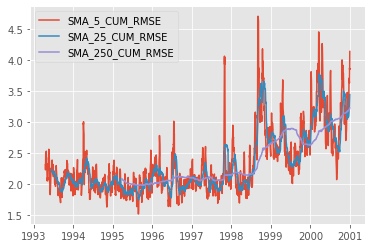

In [5]:
for WINDOW_SIZE in WINDOW_SIZES:
    plt.plot(all_stocks.index, all_stocks[f"SMA_{WINDOW_SIZE}_CUM_RMSE"], label=f"SMA_{WINDOW_SIZE}_CUM_RMSE")
plt.legend(loc="upper left")
plt.show()

### Rolling Regression

In [ ]:
start = time.time()
for WINDOW_SIZE in WINDOW_SIZES:
    all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] = 0
    for i,number in enumerate(PERMNO):
        stock = hf.create_stock_df(number,[flows, returns, tickers])
        x_small = hf.get_lags(stock, 3).dropna()
        x_full = hf.extend_variables(number, x_small, returns, flows)
        stock_LM = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.LinearRegression())
        stock_LM.columns = [f'{number}_{WINDOW_SIZE}_LM_{x}' for x in stock_LM.columns]
        stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"] = (stock_LM[f"{number}_{WINDOW_SIZE}_LM_PRED"]-stock_LM[f'{number}_{WINDOW_SIZE}_LM_RETURNS'])**2
        stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"] = stock_LM[f"{number}_{WINDOW_SIZE}_LM_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
        all_stocks[f"LM_{WINDOW_SIZE}_CUM_RMSE"] += stock_LM[f"{number}_{WINDOW_SIZE}_LM_RMSE"]
        all_stocks[stock_LM.columns]= stock_LM
        end = time.time()
        if (i+1) % 10 == 0:
            print(f"{i+1}/{100}",f"{end-start} seconds have passed")
    print("-----------------------------------------------------")

10/100 111.10735702514648 seconds have passed
20/100 217.26093101501465 seconds have passed
30/100 317.5747570991516 seconds have passed
40/100 418.49966192245483 seconds have passed
50/100 526.6185829639435 seconds have passed
60/100 633.8850040435791 seconds have passed
70/100 741.8213338851929 seconds have passed
80/100 846.5948450565338 seconds have passed
90/100 952.8162360191345 seconds have passed
100/100 1061.8848350048065 seconds have passed
10/100 1175.1989350318909 seconds have passed
20/100 1285.8692979812622 seconds have passed
30/100 1396.4161040782928 seconds have passed
40/100 1511.046956062317 seconds have passed
50/100 1623.0424389839172 seconds have passed
60/100 1745.096806049347 seconds have passed
70/100 1862.0048940181732 seconds have passed
80/100 1977.269658088684 seconds have passed
90/100 2093.8647031784058 seconds have passed
100/100 2221.7017209529877 seconds have passed
10/100 2619.1161959171295 seconds have passed
20/100 2966.803146839142 seconds have pas

In [ ]:
plt.plot(all_stocks.index, all_stocks["LM_5_CUM_RMSE"]-all_stocks["SMA_5_CUM_RMSE"], label="LM-SMA_5_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks["LM_25_CUM_RMSE"]-all_stocks["SMA_25_CUM_RMSE"], label="LM-SMA_25_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks["LM_250_CUM_RMSE"]-all_stocks["SMA_250_CUM_RMSE"], label="LM-SMA_250_CUM_RMSE")
plt.legend(loc="upper left")
plt.show()

### Rolling LASSO

In [ ]:
#hyperparameters_LASSO = {'alpha': [1,0.1, 0.01]}
hyperparameters_LASSO = {}

In [ ]:
all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for WINDOW_SIZE in WINDOW_SIZES:
    for i,number in enumerate(PERMNO):
        stock = hf.create_stock_df(number,[flows, returns, tickers])
        x_small = hf.get_lags(stock, 3).dropna()
        x_full = hf.extend_variables(number, x_small, returns, flows)
        stock_LASSO = hf.Rolling_ML(WINDOW_SIZE, x_full, linear_model.Lasso(alpha=0.5), hyperparameters=hyperparameters_LASSO, progession_param=0.3)
        stock_LASSO.columns = [f'{number}_{WINDOW_SIZE}_LASSO_{x}' for x in stock_LASSO.columns]
        stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"] = (stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_PRED"]-stock_LASSO[f'{number}_{WINDOW_SIZE}_LASSO_RETURNS'])**2
        stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"] = stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
        all_stocks[f"LASSO_{WINDOW_SIZE}_CUM_RMSE"] += stock_LASSO[f"{number}_{WINDOW_SIZE}_LASSO_RMSE"]
        all_stocks[stock_LASSO.columns]= stock_LASSO
        end = time.time()
        if (i+1) % 10 == 0:
            print(f"{i+1}/{100}",f"{end-start} seconds have passed")
    print("-----------------------------------------------------")

In [ ]:
all_stocks.columns

In [ ]:
plt.plot(all_stocks.index, all_stocks["LASSO_5_CUM_RMSE"]-all_stocks["SMA_5_CUM_RMSE"], label="LASSO-SMA_5_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks[f"LASSO_25_CUM_RMSE"]-all_stocks["SMA_25_CUM_RMSE"], label="LASSO-SMA_25_CUM_RMSE")
plt.plot(all_stocks.index, all_stocks[f"LASSO_250_CUM_RMSE"]-all_stocks["SMA_250_CUM_RMSE"], label="LASSO-SMA_250_CUM_RMSE")
plt.legend(loc="upper left")
plt.show()

In [ ]:
"""hyperparameters_RF = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split':  [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
"""
hyperparameters_RF = {}

### Rolling RandomForest

In [39]:
all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] = 0
start = time.time()
for WINDOW_SIZE in WINDOW_SIZES:
    for i,number in enumerate(PERMNO):
        stock = hf.create_stock_df(number,[flows, returns, tickers])
        x_small = hf.get_lags(stock, 3).dropna()
        x_full = hf.extend_variables(number, x_small, returns, flows, pca_n_components=10)
        x_fully = hf.add_features(x_full)
        x_fully['RETURNS'] = hf.make_market_state(x_fully['RETURNS'])
        stock_RF = hf.Normal_ML(WINDOW_SIZE, x_fully,RandomForestRegressor())
        stock_RF.columns = [f'{number}_{WINDOW_SIZE}_RF_{x}' for x in stock_RF.columns]
        stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{number}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{number}_{WINDOW_SIZE}_RF_RETURNS'])**2
        stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
        all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] += stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"]
        all_stocks[stock_RF.columns]= stock_RF
        end = time.time()
        if (i+1) % 5 == 0:
            print(f"{i+1}/{100}",f"{end-start} seconds have passed")
        plt.plot(all_stocks.index, all_stocks["RF_5_CUM_RMSE"]-all_stocks["SMA_5_CUM_RMSE"], label="RF-SMA_5_CUM_RMSE")
        plt.plot(all_stocks.index, all_stocks["RF_5_CUM_RMSE"]-all_stocks["SMA_25_CUM_RMSE"], label="RF-SMA_25_CUM_RMSE")
        plt.plot(all_stocks.index, all_stocks["RF_5_CUM_RMSE"]-all_stocks["SMA_250_CUM_RMSE"], label="RF-SMA_250_CUM_RMSE")
    print("-----------------------------------------------------")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

5/100 1.4965641498565674 seconds have passed
10/100 2.99538516998291 seconds have passed
15/100 4.566550016403198 seconds have passed
20/100 6.084567070007324 seconds have passed
25/100 7.418443918228149 seconds have passed
30/100 8.866195917129517 seconds have passed
35/100 10.190147161483765 seconds have passed
40/100 11.73043704032898 seconds have passed
45/100 13.265982151031494 seconds have passed
50/100 14.746332168579102 seconds have passed
55/100 16.262004852294922 seconds have passed
60/100 17.98043203353882 seconds have passed
65/100 19.289351224899292 seconds have passed
70/100 20.940062999725342 seconds have passed
75/100 22.589123964309692 seconds have passed
80/100 24.135752201080322 seconds have passed
85/100 25.610281229019165 seconds have passed
90/100 27.173357009887695 seconds have passed
95/100 28.969341039657593 seconds have passed
100/100 30.702948093414307 seconds have passed


In [ ]:
actions = pd.DataFrame(index=returns.index)
backtest_returns = pd.DataFrame(index=returns.index)
backtest_returns["overall"] = 0 
tau=0.012
for i,number in enumerate(PERMNO):
    stock = hf.create_stock_df(number,[flows, returns, tickers])
    x_small = hf.get_lags(stock, 3).dropna()
    x_full = hf.extend_variables(number, x_small, returns, flows)
    x_fully = hf.add_features(x_full)
    try:
        x_fully['RETURNS'] = hf.make_market_state(x_fully['RETURNS'], tau=tau)
        stock_RF = hf.Normal_ML(WINDOW_SIZE, x_fully,make_pipeline(StandardScaler(), SVC(gamma='auto')))
        stock_RF.columns = [f'{number}_{WINDOW_SIZE}_RF_{x}' for x in stock_RF.columns]
        actions[number] = stock_RF[f"{number}_{WINDOW_SIZE}_RF_PRED"]
        forward_sma = returns[number].rolling(5).mean().shift(-(5-1))
        forward_sma.iloc[-(5-1):] = returns[number].iloc[-(5-1):]
        backtest_returns[number]= forward_sma* actions[number]
        backtest_returns["overall"] += backtest_returns[number] 
        stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"] = (stock_RF[f"{number}_{WINDOW_SIZE}_RF_PRED"]-stock_RF[f'{number}_{WINDOW_SIZE}_RF_RETURNS'])**2
        stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"] = stock_RF[f"{number}_{WINDOW_SIZE}_RF_SQD_FORECAST_ERROR"].rolling(WINDOW_SIZE).mean()**0.5
        all_stocks[f"RF_{WINDOW_SIZE}_CUM_RMSE"] += stock_RF[f"{number}_{WINDOW_SIZE}_RF_RMSE"]
    except:
        continue

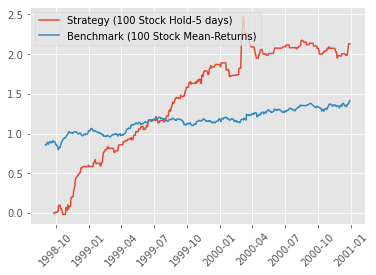

In [128]:
test_period_returns = returns.mean(axis=1).cumsum()[int(0.7*len(returns)):]
plt.plot(all_stocks.index, backtest_returns["overall"].cumsum(), label="Strategy (100 Stock Hold-5 days)")
plt.plot(test_period_returns.index,  test_period_returns , label = "Benchmark (100 Stock Mean-Returns)")
plt.plot()
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()